# データを確認する

- 各csvデータをDataFrame化して、特徴を把握する
- データを結合し、分析用のDataFrameを作成する
- 分析の方針を立てる

In [42]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

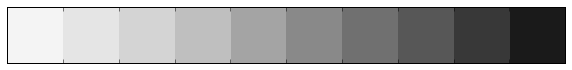

In [2]:
sns.choose_colorbrewer_palette('sequential');

# <u>１．air_reserve.csv [Airリザーブの予約データ]</u>

- 92,378レコード
- 314 /829店舗分の予約データ
- 訪問予定は、2016-01-01 19:00:00 〜 2017-05-31 21:00:00
- 予約時刻は、2016-01-01 01:00:00 〜 2017-04-22 23:00:00

In [4]:
# .csvをDataFrame化
df1 = pd.read_csv('Data/csv/air_reserve.csv')
df1.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1


In [5]:
# データ型を確認
df1.dtypes

air_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

In [6]:
# データ型を修正
df1['visit_datetime'] = df1.visit_datetime.map(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df1['reserve_datetime'] = df1.reserve_datetime.map(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df1.dtypes

air_store_id                object
visit_datetime      datetime64[ns]
reserve_datetime    datetime64[ns]
reserve_visitors             int64
dtype: object

In [9]:
# 統計量を確認
df1.describe(include='all')

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
count,92378,92378,92378,92378.000000
unique,314,4975,7513,NaN
top,air_8093d0b565e9dbdf,2016-12-24 19:00:00,2016-11-24 18:00:00,NaN
freq,2263,255,106,NaN
first,NaN,2016-01-01 19:00:00,2016-01-01 01:00:00,NaN
last,NaN,2017-05-31 21:00:00,2017-04-22 23:00:00,NaN
mean,NaN,NaN,NaN,4.481749
std,NaN,NaN,NaN,4.919669
min,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,2.000000


## １−１．月間予約数

In [25]:
#  訪問予定者数を月次で集計
df1_monthly = df1.copy()
df1_monthly['reserve_datetime'] = df1_monthly.reserve_datetime.map(lambda x: x.strftime('%Y-%m'))
drop_col = ['air_store_id','visit_datetime']
df1_monthly = df1_monthly.rename(columns={'reserve_datetime': 'reserve_month'}).drop(drop_col,axis=1)
df1_monthly = df1_monthly.groupby(['reserve_month']).count().reset_index().rename(columns={'reserve_visitors':'reserve'})
df1_monthly.head(1)

,reserve_month,reserve
0,2016-01,2936


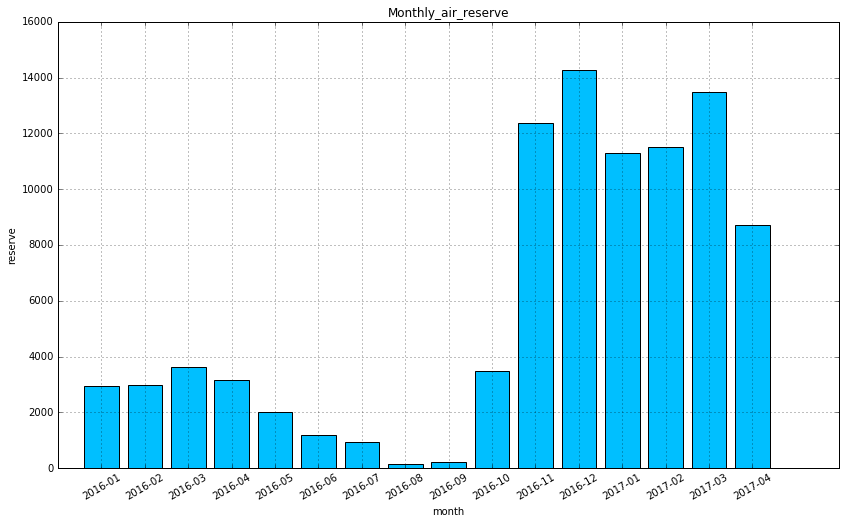

In [24]:
# 棒グラフで描画
plt.figure(figsize=(14, 8))
plt.bar(np.arange(1,17), df1_monthly.reserve.as_matrix(), tick_label=df1_monthly.reserve_month, align="center", color='deepskyblue')
plt.title("Monthly_air_reserve")
plt.xticks(rotation = 30)
plt.xlabel("month")
plt.ylabel("reserve")
plt.grid(True)

## １−２．月別訪問予定者数

In [66]:
#  訪問予定者数を月次で集計
df1_monthly = df1.copy()
df1_monthly['visit_datetime'] = df1_monthly.visit_datetime.map(lambda x: x.strftime('%Y-%m'))
drop_col = ['air_store_id','reserve_datetime']
df1_monthly = df1_monthly.rename(columns={'visit_datetime': 'visit_month'}).drop(drop_col,axis=1)
df1_monthly = df1_monthly.groupby(['visit_month'])['reserve_visitors'].sum().reset_index()
df1_monthly.head(3)

,visit_month,reserve_visitors
0,2016-01,10335
1,2016-02,11579
2,2016-03,17071


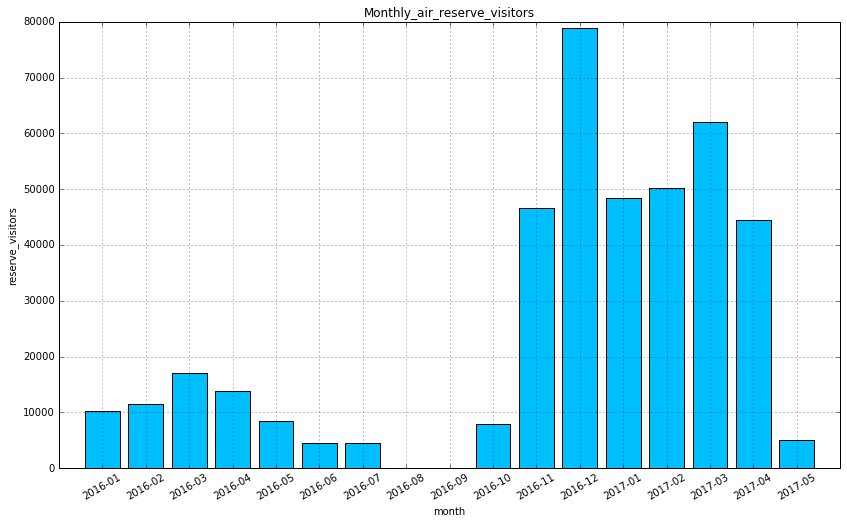

In [13]:
# 棒グラフで描画
plt.figure(figsize=(14, 8))
plt.bar(np.arange(1,18), df1_monthly.reserve_visitors.as_matrix(), tick_label=df1_monthly.visit_month, align="center", color='deepskyblue')
plt.title("Monthly_air_reserve_visitors")
plt.xticks(rotation = 30)
plt.xlabel("month")
plt.ylabel("reserve_visitors")
plt.grid(True)

## １−３．予約日から訪問予定日までの日数

In [63]:
#  予約日から訪問予定日までの日数を追加
df1_monthly = df1.copy()
df1_monthly['rsrv_2_vst'] = df1_monthly.visit_datetime - df1_monthly.reserve_datetime
df1_monthly['rsrv_2_vst'] = df1_monthly.rsrv_2_vst.map(lambda x: x.days)

df1_monthly['reserve_datetime'] = df1_monthly.reserve_datetime.map(lambda x: x.strftime('%Y-%m'))
df1_monthly = df1_monthly.rename(columns={'reserve_datetime': 'reserve_month'})

df1_monthly.tail(3)

,air_store_id,visit_datetime,reserve_month,reserve_visitors,rsrv_2_vst
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04,3,48
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04,10,42
92377,air_3cad29d1a23209d2,2017-05-31 21:00:00,2017-04,3,39


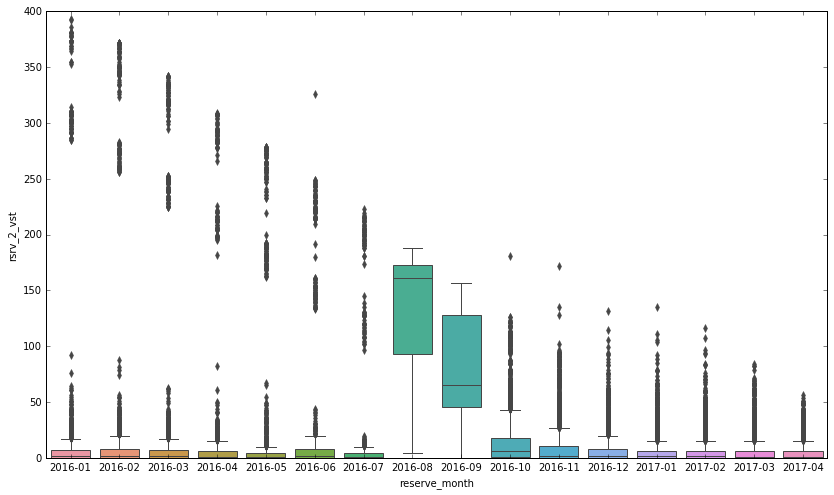

In [64]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="reserve_month", y="rsrv_2_vst", data=df1_monthly)

## １−４．気づき

### 2016年9月以前の訪問者数がそれ以降に比べて少ない
  - 2016年7月まで先行展開、2016年10月から本格展開の可能性がある
  - データがサンプリングされている可能性がある

### 忘年会、納会シーズンの予約が多い一方、歓迎会シーズンはそれほどでもないように見える
  - 休日祝日の日数による影響がある可能性がある

### ５月以降の訪問予定になっている予約データはおそらく、意図的に除外されている
  - １年前、10か月前から予約が可能な人気店がある
  - ５月以降の訪問予定になっている予約データはおそらく、意図的に除外されている（除外されていないレコードも5,000弱存在はする）

# <u>２．air_visit_data.csv [Airリザーブの訪問データ]</u>

- 252,108レコード
- 829店舗全ての履歴データがある
- 訪問日時は、2016-01-01 〜 2017-04-22

In [68]:
# .csvをDataFrame化
df3 = pd.read_csv('Data/csv/air_visit_data.csv')
df3.head(1)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25


In [69]:
# データ型を確認
df3.dtypes

air_store_id    object
visit_date      object
visitors         int64
dtype: object

In [70]:
# データ型を修正
df3['visit_date'] = df3.visit_date.map(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df3.dtypes

air_store_id            object
visit_date      datetime64[ns]
visitors                 int64
dtype: object

In [71]:
# 統計量を確認
df3.describe(include='all')

,air_store_id,visit_date,visitors
count,252108,252108,252108.000000
unique,829,478,NaN
top,air_5c817ef28f236bdf,2017-03-17 00:00:00,NaN
freq,477,799,NaN
first,NaN,2016-01-01 00:00:00,NaN
last,NaN,2017-04-22 00:00:00,NaN
mean,NaN,NaN,20.973761
std,NaN,NaN,16.757007
min,NaN,NaN,1.000000
25%,NaN,NaN,9.000000


## ２−１．月間訪問者数

In [73]:
#  訪問データを月次に加工
df3_monthly = df3.copy()
df3_monthly['visit_date'] = df3_monthly.visit_date.map(lambda x: x.strftime('%Y-%m'))
df3_monthly = df3_monthly.rename(columns={'visit_date': 'visit_month'})
df3_monthly = df3_monthly.groupby(['visit_month'])['visitors'].sum().reset_index()
df3_monthly.head(3)

,visit_month,visitors
0,2016-01,152924
1,2016-02,159934
2,2016-03,189292


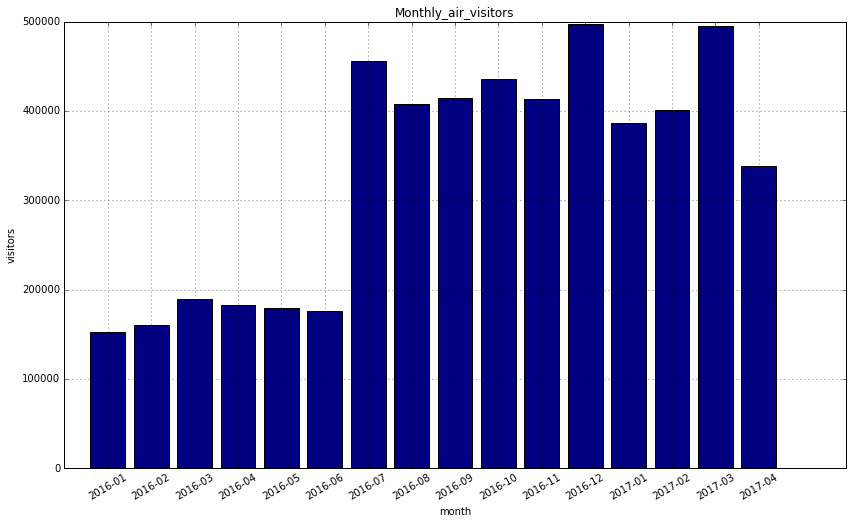

In [74]:
# 棒グラフで描画
plt.figure(figsize=(14, 8))
plt.bar(np.arange(1,17), df3_monthly.visitors.as_matrix(), tick_label=df3_monthly.visit_month, align="center", color='navy')
plt.title("Monthly_air_visitors")
plt.xticks(rotation = 30)
plt.xlabel("month")
plt.ylabel("visitors")
plt.grid(True)

## ２−２．一日の訪問者数

In [80]:
#  訪問予定月を追加
df3_monthly = df3.copy()
df3_monthly['visit_month'] = df3_monthly.visit_date.map(lambda x: x.strftime('%Y-%m'))

df3_monthly.tail(3)

,air_store_id,visit_date,visitors,visit_month
252105,air_24e8414b9b07decb,2017-04-20,7,2017-04
252106,air_24e8414b9b07decb,2017-04-21,8,2017-04
252107,air_24e8414b9b07decb,2017-04-22,5,2017-04


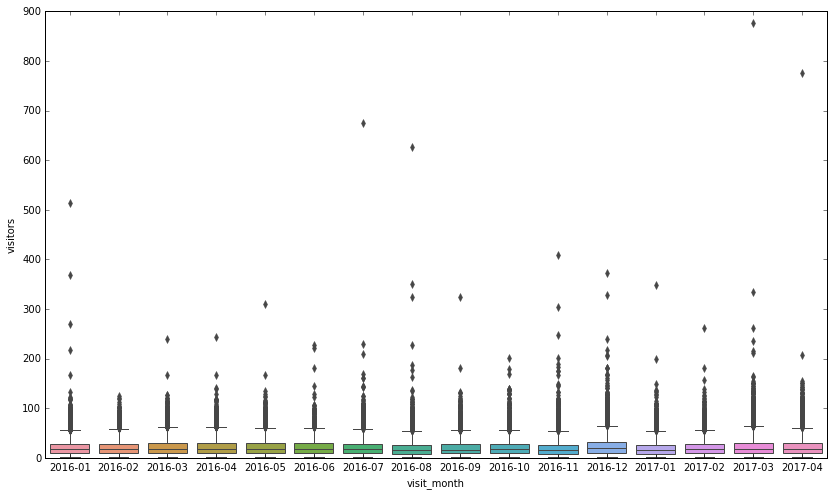

In [81]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="visit_month", y="visitors", data=df3_monthly)

## ２−３．予約データと並べて予約率を見てみる

### <u>※予約と実訪問日をキーに結合した値ではないため、参考程度に</u>

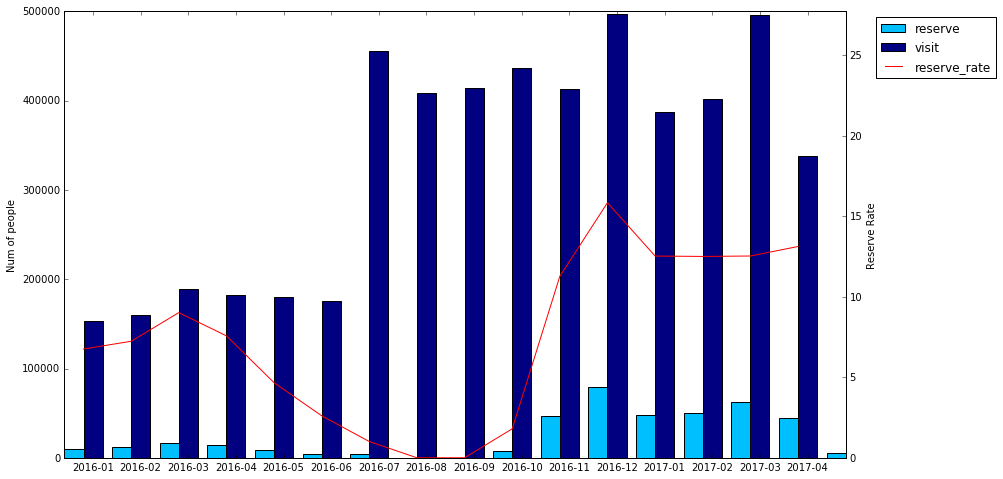

In [77]:
# 棒グラフと折れ線グラフで描画する
height1 = df1_monthly.reserve_visitors.as_matrix()
height2 = df3_monthly.visitors.as_matrix()
line_height = (df1_monthly.reserve_visitors / df3_monthly.visitors * 100).as_matrix()
w1 = 0.4
w2 = w1 / 2
left1 = np.arange(len(height1))
left2 = np.arange(len(height2))

fig, ax1 = plt.subplots(figsize=(14, 8))
p1 = ax1.bar(left1, height1, align='center', width=w1, tick_label=df1_monthly.visit_month, color='deepskyblue')
p2 = ax1.bar(left2 + w1, height2, align='center', width=w1, tick_label=df3_monthly.visit_month, color='navy')
ax1.set_ylabel('Num of people')

ax2 = ax1.twinx()
p3 = ax2.plot(left1 + w2, line_height, color="red")
ax2.set_ylabel('Reserve Rate')
ax2.set_ylim(0, np.nanmax(line_height)*1.75)

plt.legend((p1[0], p2[0], p3[0]), ("reserve", "visit", "reserve_rate"), loc='upper right', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

## ２–４．気づき

### 大口の予約が混ざっている
  - 100名を超えるような大口の予約も混ざっている

### 予約データと訪問データで充実している期間が異なる
  - 予約データは2016年11月以降、訪問データは2016年7月以降で充実している
    - 2016年7月まで先行展開、2016年10月から本格展開の可能性は否定すべきか
    - 予約機能と決済機能の展開時期が異なっていたと考えることもできる

# <u>３．air_store_info.csv [Airリザーブのレストラン情報]</u>

- 829店舗
- 14ジャンル
- 103エリア

In [84]:
# .csvをDataFrame化
df2 = pd.read_csv('Data/csv/air_store_info.csv')
df2.head(3)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852


In [85]:
# データ型を確認
df2.dtypes

air_store_id       object
air_genre_name     object
air_area_name      object
latitude          float64
longitude         float64
dtype: object

In [86]:
# 統計量を確認
df2.describe(include='all')

,air_store_id,air_genre_name,air_area_name,latitude,longitude
count,829,829,829,829.000000,829.000000
unique,829,14,103,NaN,NaN
top,air_064e203265ee5753,Izakaya,Fukuoka-ken Fukuoka-shi Daimyō,NaN,NaN
freq,1,197,64,NaN,NaN
mean,NaN,NaN,NaN,35.647042,137.415311
std,NaN,NaN,NaN,2.084659,3.650971
min,NaN,NaN,NaN,33.211967,130.195555
25%,NaN,NaN,NaN,34.695124,135.341564
50%,NaN,NaN,NaN,35.658068,139.685474
75%,NaN,NaN,NaN,35.694003,139.751599


## ３−１．ジャンルごとの店舗数

In [95]:
# ジャンルの内訳と頻度
df2.groupby('air_genre_name').size().sort_values(ascending=False).head(3)

air_genre_name
Izakaya        197
Cafe/Sweets    181
Dining bar     108
dtype: int64

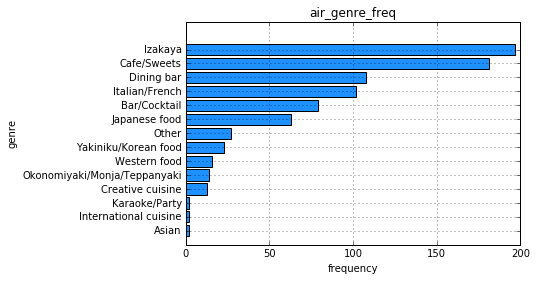

In [88]:
# 棒グラフで描画
df2_air_genre_name = df2.groupby('air_genre_name').size().sort_values()
plt.barh(np.arange(1,15), df2_air_genre_name.values, tick_label=df2_air_genre_name.index, align="center", color='dodgerblue')
plt.title("air_genre_freq")
plt.xlabel("frequency")
plt.ylabel("genre")
plt.grid(True)

## ３−２．エリアごとの店舗数

In [96]:
# エリアの内訳と頻度
df2.groupby('air_area_name').size().sort_values(ascending=False).describe()

count    103.000000
mean       8.048544
std       11.332219
min        2.000000
25%        2.000000
50%        4.000000
75%        7.500000
max       64.000000
dtype: float64

## ３−２−１．市区町村ごとの店舗数

In [91]:
# エリアを市区町村レベルに変更、plot時の文字化け対策で置換
df2_city = df2.copy()
df2_city['air_area_name'] = df2_city.air_area_name.map(lambda x: ' '.join(x.split(' ')[:2]).translate(str.maketrans('Ōōū', 'Oou')))
df2_city.head(3)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyogo-ken Kobe-shi,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyogo-ken Kobe-shi,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyogo-ken Kobe-shi,34.695124,135.197852


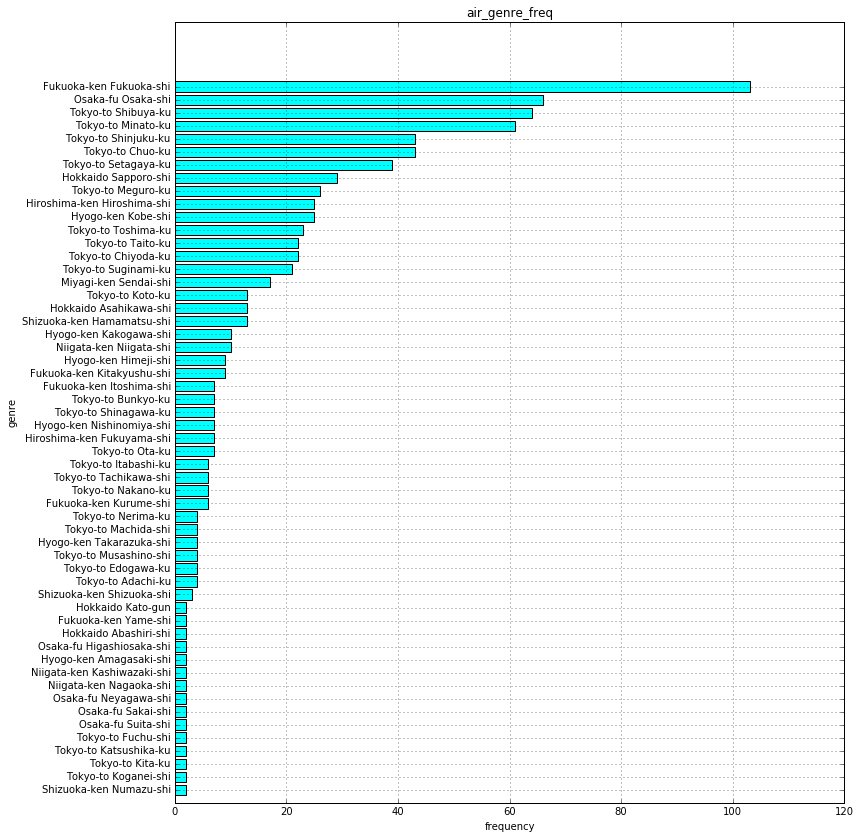

In [93]:
# 棒グラフで描画
df2_air_area_name = df2_city.groupby('air_area_name').size().sort_values()
plt.figure(figsize=(12, 14))
plt.barh(np.arange(1,56), df2_air_area_name.values, tick_label=df2_air_area_name.index, align="center", color='aqua')
plt.title("air_genre_freq")
plt.xlabel("frequency")
plt.ylabel("genre")
plt.grid(True)

## ３−２−２．都道府県ごとの店舗数

In [97]:
# エリアを都道府県レベルに変更
df2_pref = df2_city.copy()
df2_pref['air_area_name'] = df2_pref.air_area_name.map(lambda x: ' '.join(x.split(' ')[:1]))
df2_pref.head(3)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyogo-ken,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyogo-ken,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyogo-ken,34.695124,135.197852


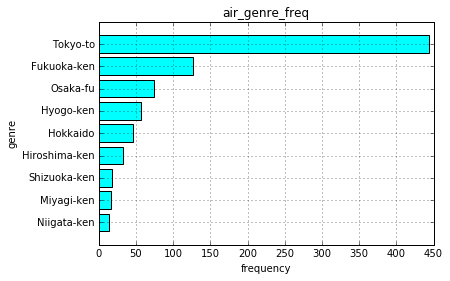

In [98]:
# 棒グラフで描画
df2_air_area_name = df2_pref.groupby('air_area_name').size().sort_values()
plt.barh(np.arange(1,10), df2_air_area_name.values, tick_label=df2_air_area_name.index, align="center", color='aqua')
plt.title("air_genre_freq")
plt.xlabel("frequency")
plt.ylabel("genre")
plt.grid(True)

## ３−３．エリア x ジャンルの分布

In [100]:
# データフレームをピボット
df2_pref_heat = pd.pivot_table(data=df2_pref, values='air_store_id', 
                                  columns='air_area_name', index='air_genre_name', aggfunc='count').sort_values(by='Tokyo-to',ascending=False)
df2_pref_heat = df2_pref_heat.T.sort_values(by='Izakaya',ascending=False)
df2_pref_heat.head(3)

air_genre_name,Cafe/Sweets,Izakaya,Dining bar,Italian/French,Bar/Cocktail,Japanese food,Other,Western food,Creative cuisine,Okonomiyaki/Monja/Teppanyaki,Yakiniku/Korean food,Asian,International cuisine,Karaoke/Party
air_area_name,,,,,,,,,,,,,,
Tokyo-to,87.0,87.0,65.0,65.0,54.0,38.0,16.0,14.0,5.0,5.0,4.0,2.0,2.0,NaN
Fukuoka-ken,45.0,27.0,14.0,11.0,9.0,11.0,5.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN
Hyogo-ken,10.0,24.0,4.0,9.0,NaN,2.0,NaN,NaN,4.0,2.0,2.0,NaN,NaN,NaN


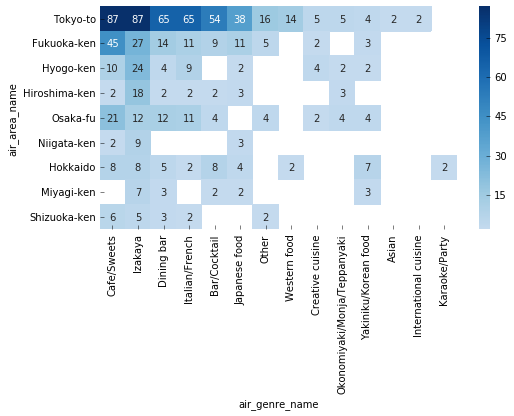

In [101]:
# ヒートマップを描画
plt.figure(figsize=(8, 4))
sns.heatmap(df2_pref_heat, annot=True, center=30, fmt='g', cmap='Blues')

## ３–４．気づき

### ジャンル x エリアの分布に規則性が見られる
  - 何らかのルールでサンプリングされていそう

# <u>４．hpg_reserve.csv [ホットペッパーグルメの予約データ]</u>

- 2,000,320レコード
- 13,325 /4,690店舗の予約データ???
- 訪問予定は、2016-01-01 11:00:00 〜 2017-05-31 23:00:00
- 予約時刻は、2016-01-01 00:00:00 〜 2017-04-22 23:00:00

In [102]:
# .csvをDataFrame化
df4 = pd.read_csv('Data/csv/hpg_reserve.csv')
df4.head(3)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
